# Top casing source

### Using the em/feat/muinversion branch of SimPEG (http://github.com/simpeg/simpeg)

In [1]:
from CasingSimulations import * 
%matplotlib inline

In [2]:
directory = '1kmCasing-TopCasingSource-Break'
cpfile = "CasingProperties.json"
resultsfile = "CasingBreak.hdf5"
rerun = False

# Model Parameters

In [3]:
# Save or load Results
cp_file = '{directory}/{cpfile}'.format(directory=directory, cpfile=cpfile)

freqs = [1.]
muModels = [50.]
broken_z = np.r_[-860., -850]
if rerun is True:   
    cp = CasingProperties(dsz=0., freqs=freqs, muModels=muModels)
else:   
    with open(cp_file, 'r') as outfile:   
        cp = CasingProperties.deserialize(json.load(outfile))

In [4]:
mesh = CasingMesh(cp).mesh

In [5]:
print(
    'Cyl Mesh Extent xmax: {},: zmin: {}, zmax: {}'.format(
        mesh.vectorCCx.max(),
        mesh.vectorCCz.min(),
        mesh.vectorCCz.max()
    )
)

print(mesh.nC)
print([500./np.sqrt(cp.sigmaback*f) for f in cp.freqs])
print([500./np.sqrt(cp.sigmacasing*f) for f in cp.freqs])

Cyl Mesh Extent xmax: 702446.341501,: zmin: -615296.090052, zmax: 614296.590053
2450492
[5000.0]
[0.21320071635561044]


# plot model

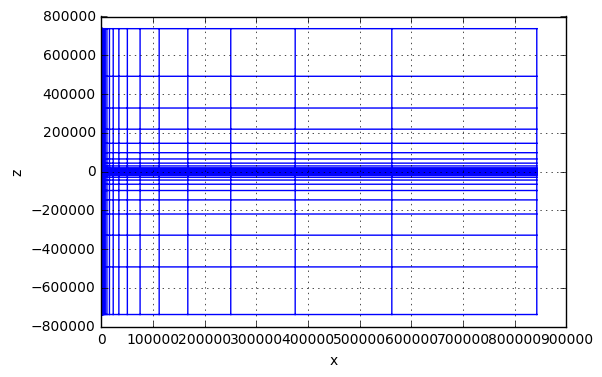

In [6]:
fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

# fig.savefig('{}/{}'.format(directory, 'CylMesh.png'))

In [7]:
indActive=mesh.gridCC[:,2] <= 0.
casingMap = Maps.ParametrizedCasingAndLayer(mesh, indActive=indActive, slope=1e8)
actMap_sigma = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=np.log(cp.sigmaair))
actMap_mu = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=mu_0)
expMap = Maps.ExpMap(mesh)

sigmaMap = expMap * actMap_sigma * casingMap
muMap = actMap_mu * casingMap

In [8]:
muModelInd = 0

sigma_m = np.r_[
    np.log(cp.sigmaback), np.log(cp.sigmalayer), np.log(cp.sigmacasing), np.log(cp.sigmainside),
    cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
    cp.casing_z[0], cp.casing_z[1]
]

mu_m = np.r_[
    mu_0, mu_0, cp.muModels[muModelInd]*mu_0, mu_0,
    cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
    cp.casing_z[0], cp.casing_z[1]
]

In [9]:
%%time
sigma = sigmaMap * sigma_m
mu = muMap * mu_m

CPU times: user 22.8 s, sys: 467 ms, total: 23.3 s
Wall time: 23.5 s


In [10]:
broken_ind = (
    (mesh.gridCC[:,0] < cp.casing_b) &
    (mesh.gridCC[:,2] >= broken_z.min()) &
    (mesh.gridCC[:,2] <= broken_z.max())
)

sigma[broken_ind] = cp.sigmainside
mu[broken_ind] = mu_0

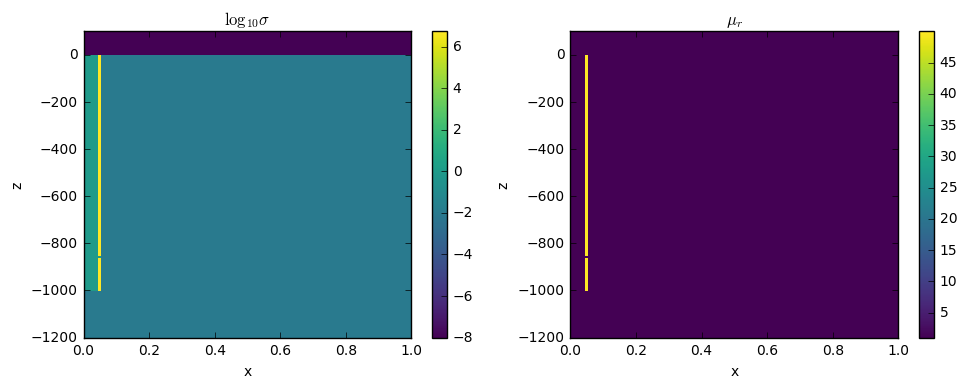

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax = plotModels(mesh, sigma, mu, xlim=[0.,1.], zlim=[-1200., 100.], ax=ax)
# fig.savefig('{}/{}'.format(directory, 'PhysPropModels'))

# Set up the Source

In [12]:
# top-casing-source
thSrc = TopCasingSource(mesh, cp.src_a, cp.src_b, cp.casing_a, cp.freqs)

(-1.0, 1.0)

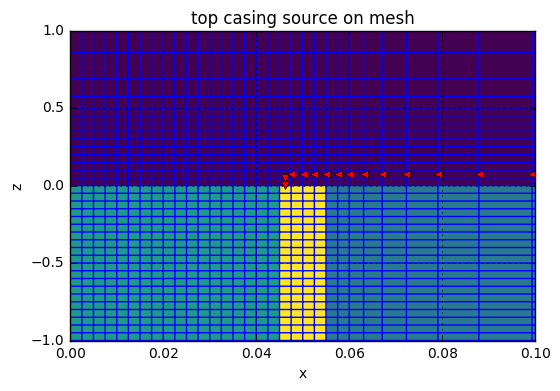

In [13]:
# Plot the source to make sure the path is infact
# connected

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
mesh.plotImage(np.log10(sigma), ax=ax)
mesh.plotGrid(ax=ax)
thSrc.plotSrc(ax=ax)

ax.set_title('top casing source on mesh')

ax.set_xlim([0, 0.1])
ax.set_ylim([-1., 1.])

# fig.savefig('{}/{}'.format(directory, 'SourceOnMesh.png'))

# Problem and Survey

In [14]:
prob = FDEM.Problem3D_h(mesh, sigma=sigma, muMap=Maps.IdentityMap(mesh))
survey = FDEM.Survey(thSrc.s_e)
prob.solver = Solver
prob.pair(survey)

In [15]:
def MuCasingModel(mucasing):
    return mu

In [16]:
fields = {}

In [17]:
if rerun is True:
    # create a file to store results
    results = h5py.File("{}/{}".format(directory, resultsfile), "w")
else:
    results = h5py.File("{}/{}".format(directory, resultsfile), "r")

In [18]:
results.keys()

[u'fields_50']

In [19]:
%%time
for muMod in cp.muModels:
    tag = int(muMod)
    curMu = MuCasingModel(muMod)

    if rerun is True:
        print('solving mu = {}mu_0'.format(tag))
        fields[tag] = prob.fields(curMu)
        dbentry = "fields_{tag}".format(tag=tag)
        results.create_dataset(dbentry, data=fields[tag][:,'hSolution'])
        print('... saved fields_{tag}'.format(tag=tag))
        
        # Save parameters used to produce these fields
        with open(cp_file, 'w') as outfile:
            json.dump(cp.serialize(), outfile)

    else:
        print('loading mu = {}mu_0'.format(tag))
        prob.model = curMu
        f = prob.fieldsPair(mesh, survey)
        f[:, 'hSolution'] = results['fields_{}'.format(tag)].value
        fields[tag] = f
        print('... loaded mu = {}mu_0'.format(tag))

loading mu = 50mu_0
... loaded mu = 50mu_0
CPU times: user 5.67 s, sys: 2.02 s, total: 7.7 s
Wall time: 8.27 s


1.0 Hz, 50.0 mu_0


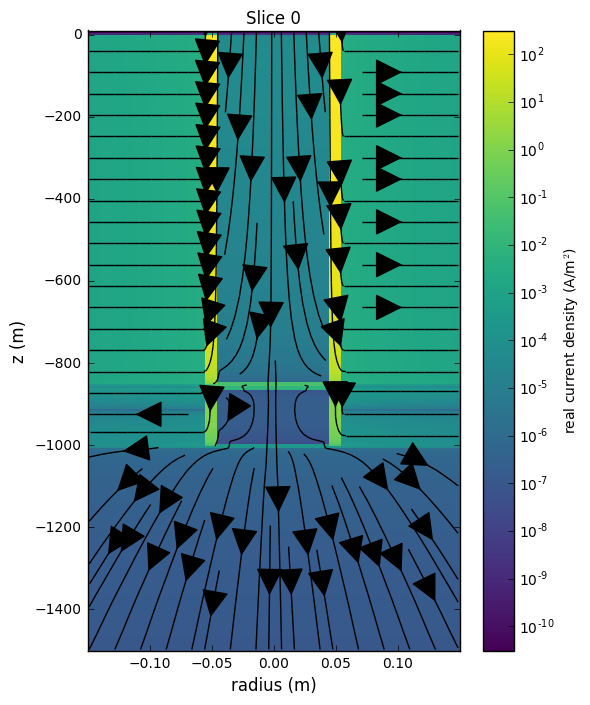

In [24]:
def vecplot_j(muind, freqind, reim='real', th_bh = 'th'):
    fig, ax = plt.subplots(1,1, figsize=(6,8))
    src = survey.getSrcByFreq(survey.freqs[freqind])
    src = src[0] # if th_bh == 'bh' else src[1]
    mur = cp.muModels[muind]
    
    print('{} Hz, {} mu_0'.format(cp.freqs[freqind], mur))
    ax1 = plotCurrentDensity(
        mesh, fields[mur][src, 'j'], csx=0.0025, csz=5., 
        xmax=0.15, zmin=10., zmax=-1500., real_or_imag=reim, mirror=True, ax=ax, fig=fig, saveFig=True
    )
    return ax1

w = widgets.interactive(
        vecplot_j, muind=widgets.IntSlider(min=0, max=len(cp.muModels)-1, continuousUpdate=False),
        freqind=widgets.IntSlider(min=0, max=len(cp.freqs)-1, continuousUpdate=False),
        reim=widgets.ToggleButtons(options=['real', 'imag'], continuousUpdate=False), 
        th_bh=widgets.ToggleButtons(options=['th', 'bh'], continuousUpdate=False)
)
w
#ax.axis('equal', adjustable='box')

In [25]:
survey

In [26]:
%%time 

IxCasing, IzCasing = CasingCurrents(cp, fields, mesh, survey)

CPU times: user 627 ms, sys: 742 ms, total: 1.37 s
Wall time: 1.97 s


mu = 50.0 mu_0


IndexError: list index out of range

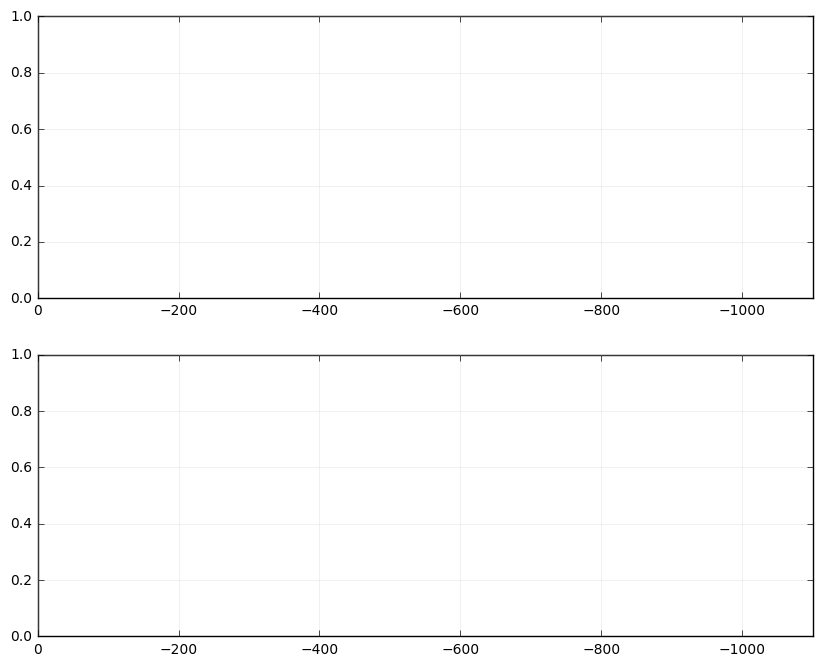

In [28]:
def plotMe_freq(muopt, reim, subtract=None):
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    mur = cp.muModels[muopt]
    pltz = {50: -1*IzCasing[50.]}
    plot_currents_over_freq(
        IxCasing, pltz, cp, mesh, mur, subtract=subtract, real_or_imag=reim, 
        ax=ax
    )  
    

w = widgets.interact(
    plotMe_freq, 
    muopt=widgets.IntSlider(min=0., max=len(cp.muModels)-1), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1])
)


In [28]:
def plotMe_mu(freqopt, reim, subtract=None):
#     fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    plot_currents_over_mu(IxCasing, IzCasing, cp, mesh, freqopt, subtract=subtract, real_or_imag=reim)  

w = widgets.interact(
    plotMe_mu, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1])
)

w

TypeError: bad operand type for unary -: 'dict'

<function __main__.plotMe_mu>

In [ ]:
def plotMe_j_mu_z(freqopt, reim, r, subtract=None):
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    plot_j_over_mu_z(
        cp, fields, mesh, survey, freqopt, subtract=subtract, r=r, 
        real_or_imag=reim, ax=ax
    )  
#     ax[1].set_ylim([1e-4, 3e-4])

widgets.interact(
    plotMe_j_mu_z, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1), 
    r=widgets.FloatText(value=1.), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1])
)

In [ ]:
def plotMe_j_mu_x(freqopt, reim, z, subtract=None):
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    plot_j_over_mu_x(cp, fields, mesh, survey, freqopt, subtract=subtract, z=z, real_or_imag=reim, ax=ax)
    plt.show()

j_over_x = widgets.interactive(
    plotMe_j_mu_x, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuous_update=False), 
    z=widgets.FloatText(value=-950., continuous_update=False), 
    subtract=widgets.ToggleButtons(options=[None, 1], continuous_update=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag'], continuous_update=False)
)
j_over_x